In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from umap import UMAP
import pandas as pd
import tables
import umap.plot
import scipy
from  sklearn.cluster import KMeans
import hdbscan


DATA_DIR             = "/home/camata/work/kaggle-multimodal/"
FP_CELL_METADATA     = os.path.join(DATA_DIR,"metadata.csv")
FP_CITE_TRAIN_INPUTS = os.path.join(DATA_DIR,"train_cite_inputs.h5")



2022-10-13 19:43:27.736189: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [3]:
cite_train = pd.read_hdf(FP_CITE_TRAIN_INPUTS)
metadata   = pd.read_csv(FP_CELL_METADATA)
metadata.head()

,cell_id,day,donor,cell_type,technology
0,c2150f55becb,2,27678,HSC,citeseq
1,65b7edf8a4da,2,27678,HSC,citeseq
2,c1b26cb1057b,2,27678,EryP,citeseq
3,917168fa6f83,2,27678,NeuP,citeseq
4,2b29feeca86d,2,27678,EryP,citeseq


In [7]:
mapper = umap.UMAP( n_neighbors=50,min_dist=0.0,n_components=2,n_epochs=10,low_memory=True).fit_transform(cite_train.values)

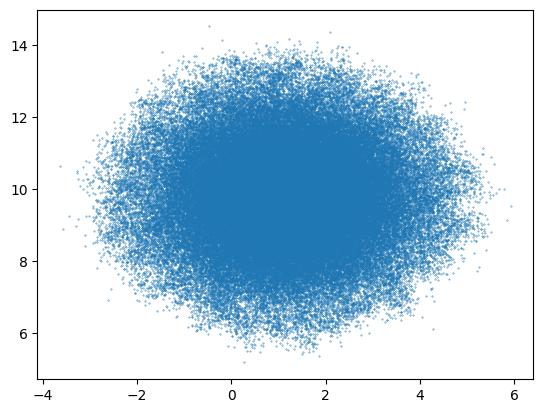

In [8]:
plt.scatter(mapper[:, 0], mapper[:, 1],s=0.1, cmap='Spectral')
plt.savefig('umap_scatter.png')
plt.show()

In [9]:

labels = hdbscan.HDBSCAN(
    min_samples=10,
    min_cluster_size=500,
).fit_predict(mapper)

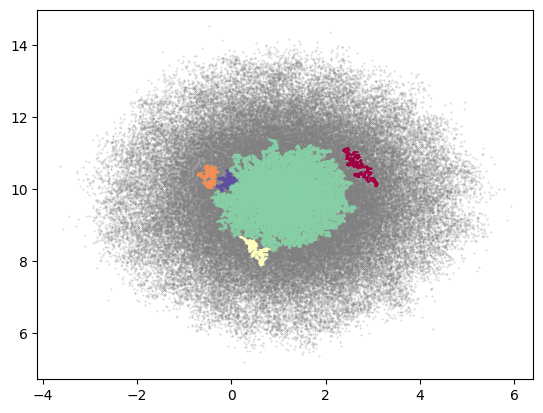

In [10]:
clustered = (labels >= 0)
plt.scatter(mapper[~clustered, 0],
            mapper[~clustered, 1],
            color=(0.5, 0.5, 0.5),
            s=0.1,
            alpha=0.5)
plt.scatter(mapper[clustered, 0],
            mapper[clustered, 1],
            c=labels[clustered],
            s=0.1,
            cmap='Spectral');
plt.show()